> # Facial Expression Recognition



# Intro
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories:

| category  | emotion  |
|:---:|:---|
| 0  | Angry  |
| 1  |  Disgust |
| 2  |  Fear |
| 3  |  Happy |
| 4  |  Sad |
| 5  |  Surprise |
| 6  | Neutral |

We define a simple CNN model and compare the predicted results with ge given labels.

# <span style="color: royalblue;">Libraries</span>
We load some standard libraries and packages of sklearn and keras.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.utils import to_categorical

# Path and Load Data
Load the image data with labels.

In [7]:
dataset_path = "dataset/csvs"
csvs = os.listdir(dataset_path)

In [8]:
li = []
for csv_file in csvs:
    li.append(pd.read_csv(os.path.join(dataset_path, csv_file)))
    
data = pd.concat(li, axis=0, ignore_index=True)

data.columns = ['emotion', 'usage', 'pixels']
data.head()

,emotion,usage,pixels
0,3,PublicTest,85 181 177 181 82 84 144 35 167 182 127 0 125 ...
1,4,PublicTest,132 57 102 50 76 102 134 162 179 191 189 210 2...
2,4,PublicTest,206 201 195 193 193 198 199 187 178 174 170 16...
3,0,PublicTest,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,3,PublicTest,199 199 200 200 198 196 140 116 129 124 96 95 ...


In [9]:
data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


# <span style="color: royalblue;">Functions</span>
We define some helper functions for preparing and ploting the data.

In [4]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_img, test_img_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_img[image_number], 'gray')
    axs[0].set_title(emotions[test_img_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number])
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index())
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

# <span style="color: royalblue;">Overview</span> 

In [11]:
data['usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: usage, dtype: int64

# Prepare Data

In [6]:
emotions = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

Define training, validation and test data:

In [31]:
# datasets for development 
train_data = data[data['usage']=='Training'][:1000]
val_data = data[data['usage']=='PrivateTest'][:100]
test_data = data[data['usage']=='PublicTest'][:100]


train_img, train_img_label = prepare_data(train_data)
val_img, val_img_label = prepare_data(val_data)
test_img, test_img_label = prepare_data(test_data)

Reshape and scale the images:

In [32]:
train_images = train_img.reshape((train_img.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_img.reshape((val_img.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_img.reshape((test_img.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

Encoding of the target value:

In [33]:
train_labels = to_categorical(train_img_label)
val_labels = to_categorical(val_img_label)
test_labels = to_categorical(test_img_label)

In [34]:
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

# <span style="color: royalblue;">Some Examples</span> 

## All Emotions

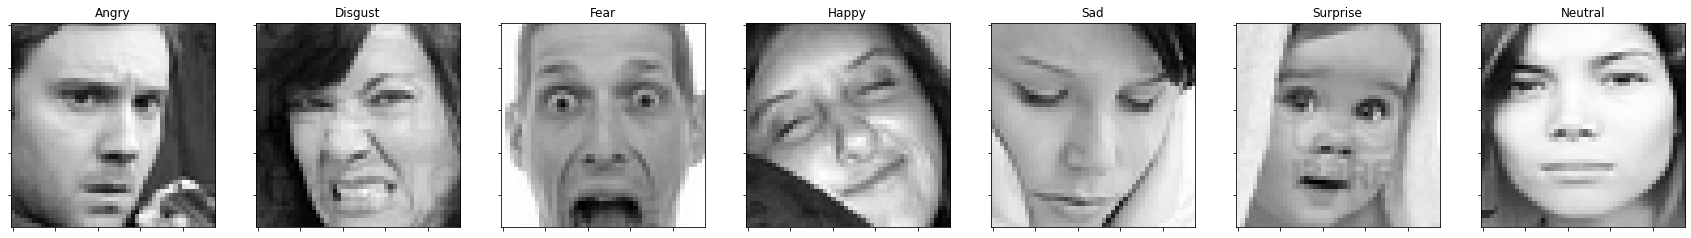

In [35]:
plot_all_emotions()

## Angry

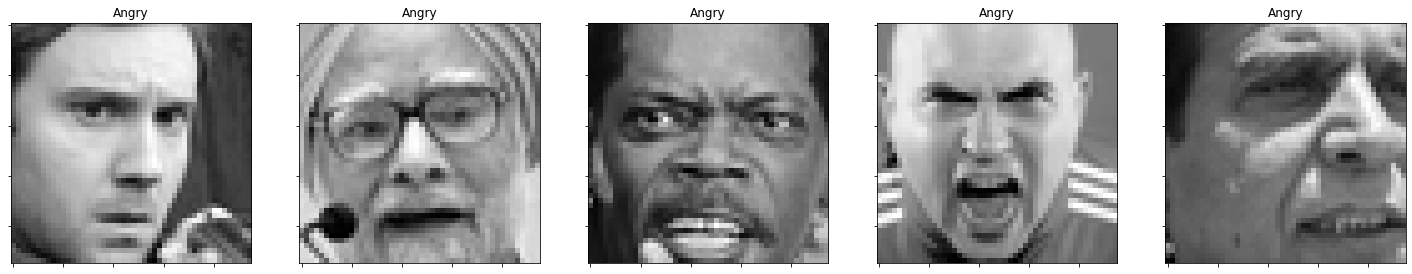

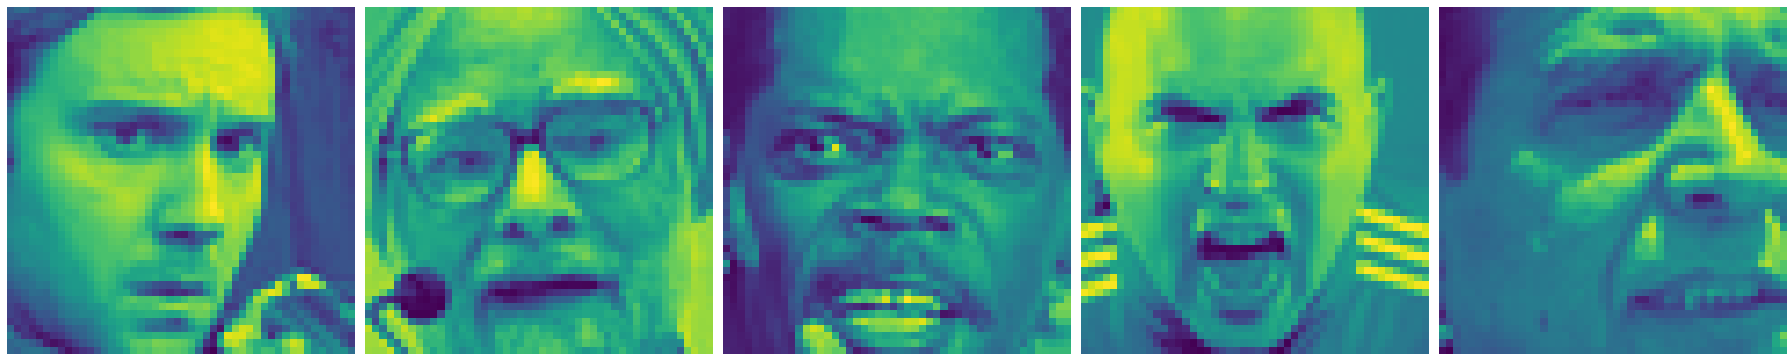

In [87]:
plot_examples(label=0)

## Disgust

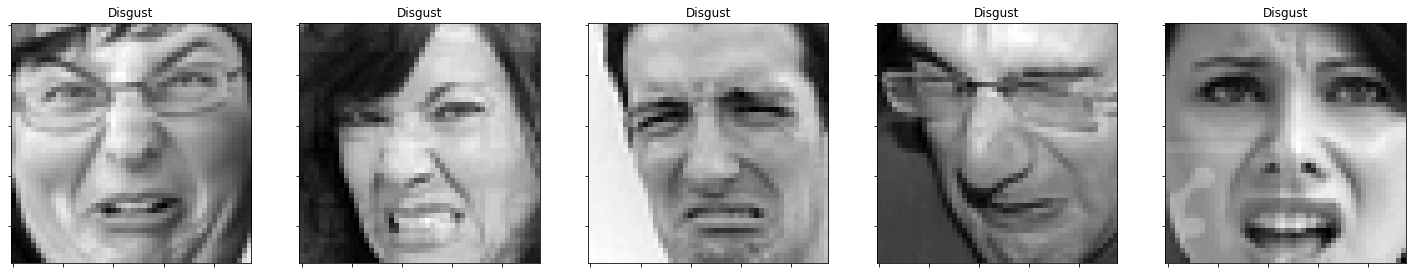

In [37]:
plot_examples(label=1)

## Fear

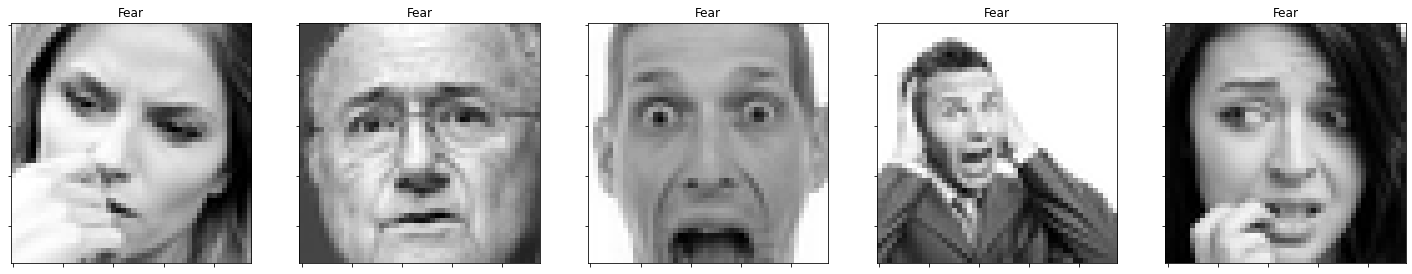

In [38]:
plot_examples(label=2)

## Happy

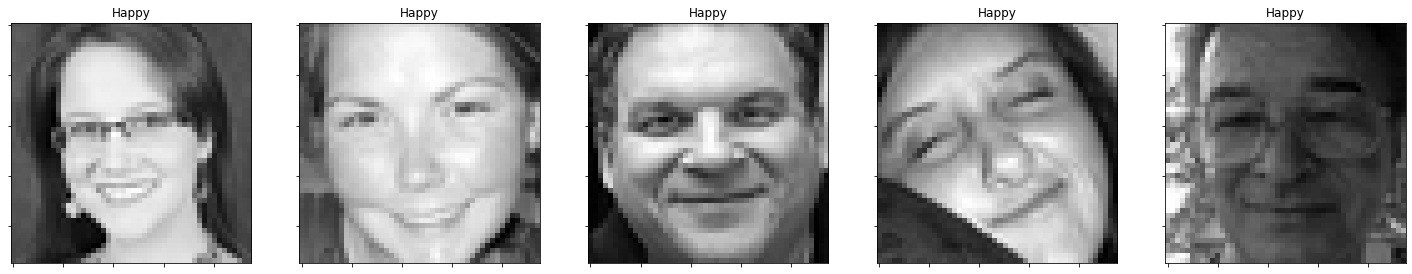

In [39]:
plot_examples(label=3)


## Sad

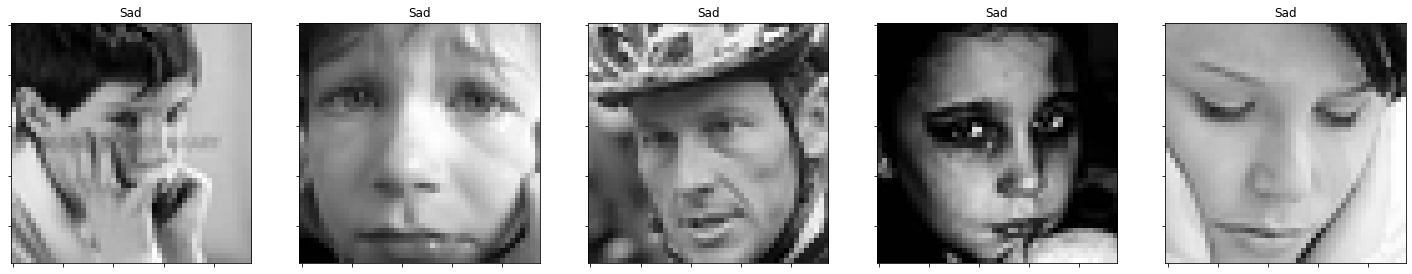

In [40]:
plot_examples(label=4)

## Surprise

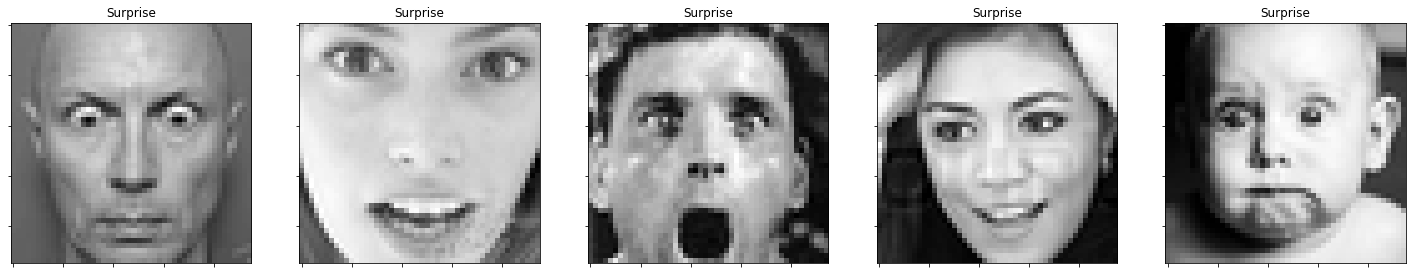

In [41]:
plot_examples(label=5)

## Neutral

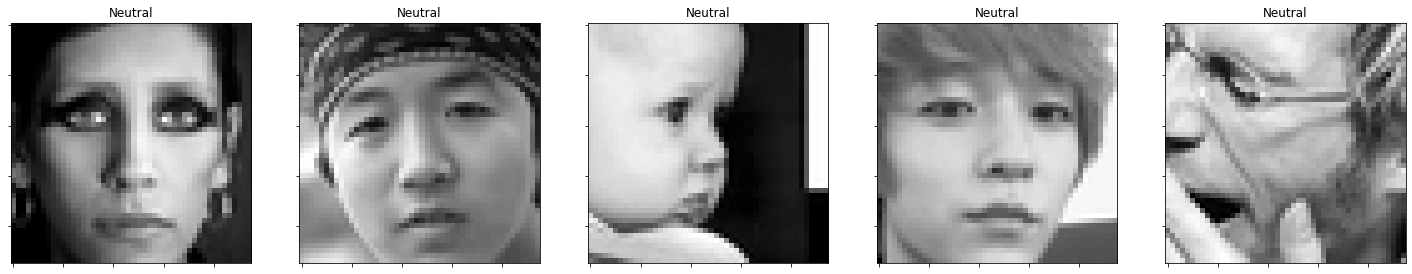

In [42]:
plot_examples(label=6)

# <span style="color: royalblue;">Distribution Of Labels</span> 

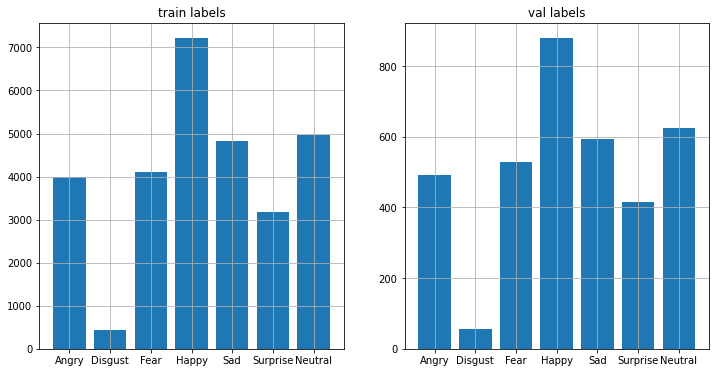

In [43]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

# <span style="color: royalblue;">Class Weights</span> 
Calculate the class weights of the label distribution:

In [44]:
class_weight = dict(zip(range(0, 7), (((data[data['usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['usage']=='Training']['emotion'])).tolist()))

In [45]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

# <span style="color: royalblue;">Model</span> 
We define a simple CNN model:

In [46]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [47]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [49]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=10,
                    batch_size=64
                    )

Epoch 1/10
449/449 [==============================] - 79s 175ms/step - loss: 0.2781 - accuracy: 0.2856 - val_loss: 1.5408 - val_accuracy: 0.4310
Epoch 2/10
449/449 [==============================] - 79s 176ms/step - loss: 0.2257 - accuracy: 0.4380 - val_loss: 1.4080 - val_accuracy: 0.4787
Epoch 3/10
449/449 [==============================] - 79s 175ms/step - loss: 0.2012 - accuracy: 0.5075 - val_loss: 1.3157 - val_accuracy: 0.5088
Epoch 4/10
449/449 [==============================] - 79s 176ms/step - loss: 0.1867 - accuracy: 0.5411 - val_loss: 1.2810 - val_accuracy: 0.5305
Epoch 5/10
449/449 [==============================] - 79s 176ms/step - loss: 0.1760 - accuracy: 0.5697 - val_loss: 1.2454 - val_accuracy: 0.5428
Epoch 6/10
449/449 [==============================] - 79s 175ms/step - loss: 0.1655 - accuracy: 0.5940 - val_loss: 1.2433 - val_accuracy: 0.5313
Epoch 7/10
449/449 [==============================] - 79s 177ms/step - loss: 0.1556 - accuracy: 0.6156 - val_loss: 1.2216 - val_ac

In [51]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 3s 24ms/step - loss: 1.3331 - accuracy: 0.5475
test caccuracy: 0.5475062727928162


In [52]:
pred_test_labels = model.predict(test_images)

# <span style="color: royalblue;">Analyse Convergence</span> 

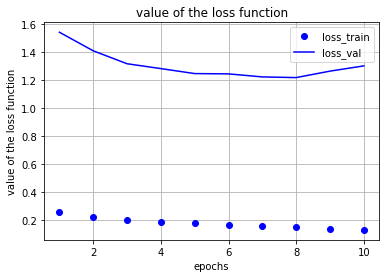

In [53]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

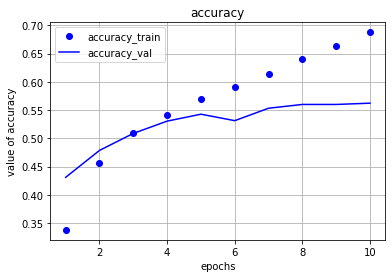

In [54]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

# <span style="color: royalblue;">Analyse Results</span> 

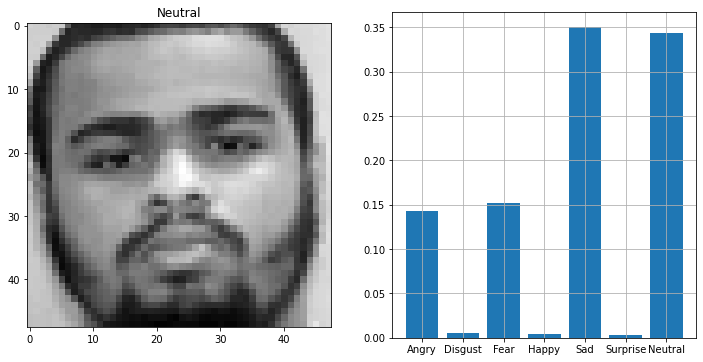

In [55]:
plot_image_and_emotion(test_img, test_img_label, pred_test_labels, 106)

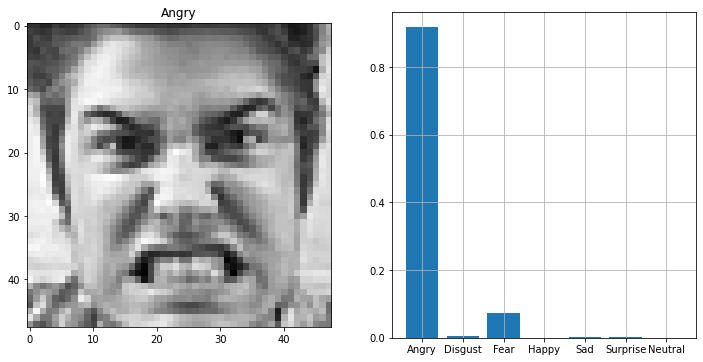

In [56]:
plot_image_and_emotion(test_img, test_img_label, pred_test_labels, 40)

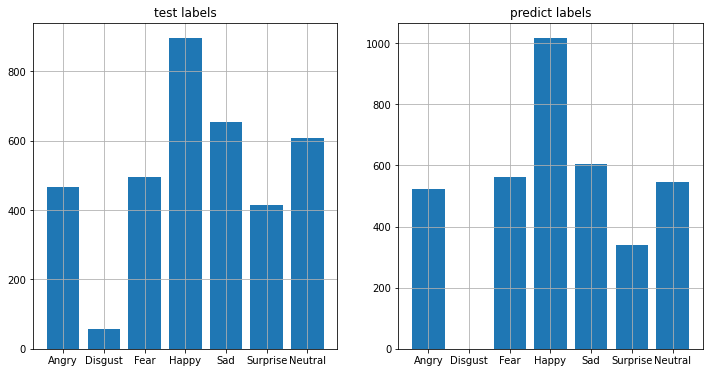

In [57]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

# <span style="color: royalblue;">Analyse Wrong Prediction</span>
The accuracy score is about 54% on the test set. So it is obvious to take focus on the wrong predictions. We want to extract details to improve the model.

In [58]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

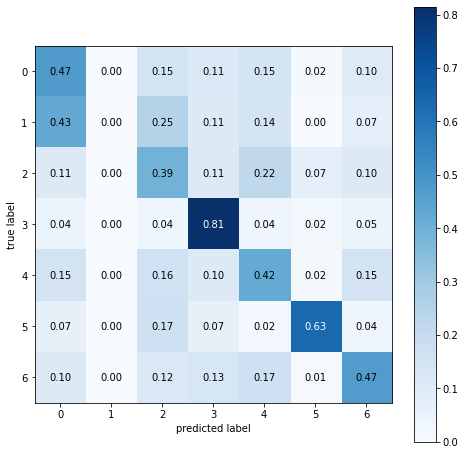

In [69]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

classes = list(emotions.values())

fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat,
    colorbar=True,
    show_absolute=False,
    show_normed=True,
    # class_names=classes,
    figsize=(8, 8)
)

fig.show()

# VGG16 MODEL

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

In [4]:
train_path = 'dataset/base_images/train'
valid_path = 'dataset/base_images/val'
test_path = 'dataset/base_images/test'

In [5]:
idg = ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches =  idg.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    classes=['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'], 
    batch_size=10
)

valid_batches = idg.flow_from_directory(
    directory=valid_path, 
    target_size=(224,224), 
    classes=['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'], 
    batch_size=10
)

test_batches = idg.flow_from_directory(
    directory=test_path, 
    target_size=(224,224), 
    classes=['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'], 
    batch_size=10, 
    shuffle=False
)

Found 52423 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [6]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

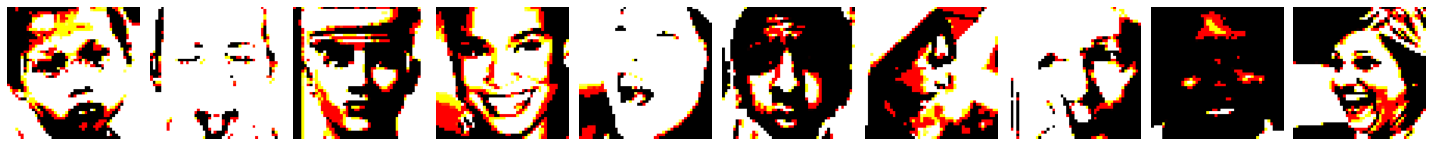

[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


In [7]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(imgs)
print(labels)

In [8]:
vgg16_model = VGG16()

In [9]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
new_model = models.Sequential()
for layer in vgg16_model.layers[:-1]:
    new_model.add(layer)

In [12]:
for layer in new_model.layers:
    layer.trainable = False

In [13]:
new_model.add(Dense(units=7, activation='softmax'))

In [14]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [15]:
new_model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
new_history = new_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=5,
    verbose=2
)

Epoch 1/5


KeyboardInterrupt: 